In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from umap import UMAP
import umap.plot as uplot
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import NeighborhoodComponentsAnalysis as NCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
import pandas as pd
import sys; sys.path.insert(0, '..')
from stattest import Analysis
# from clustering import ClusteringPipe

df = pd.read_csv('data_processed.csv')
Class = pd.Categorical(df['class'])
y = pd.DataFrame({'class':Class.codes})
X = df.drop([ 'class'], axis=1)
from sklearn.preprocessing import MinMaxScaler
X_scaled = MinMaxScaler().fit_transform(X.iloc[:,:21])
X_std = StandardScaler().fit_transform(X.iloc[:,:21])

In [3]:
def present_results(results):
    print('Mean:')
    print(results.mean())
    print('Annova:')
    print(results.annova())
    print('Scheffe:')
    print(results.scheffe())
    return results.plot()

## DImension Reduction Methods

In [219]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

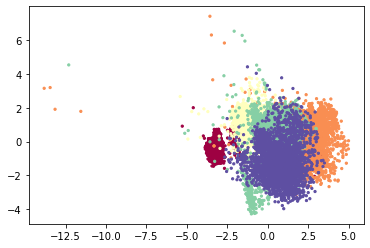

In [259]:
X_lda = LDA().fit_transform(X_std, Class)
plt.scatter(X_lda[:,0], X_lda[:,1], c=Class, cmap='Spectral', s=5)

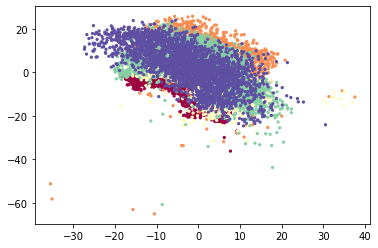

In [257]:
X_nca = NCA().fit_transform(X_std, Class)
plt.scatter(X_nca[:,0], X_nca[:,1], c=Class, cmap='Spectral', s=5)

In [5]:
# project the 64-dimensional data to a lower dimension
umap = UMAP(n_components=5, n_neighbors=50, min_dist=0.4, negative_sample_rate=2, spread=0.5)
X_umap = umap.fit_transform(X)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

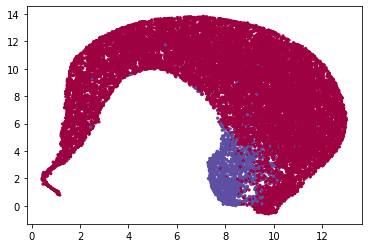

In [4]:
X_umap_2d = UMAP(n_neighbors=50, min_dist=0.4, negative_sample_rate=2, spread=0.5).fit_transform(X)
plt.scatter(X_umap_2d[:,0], X_umap_2d[:,1], c=Class, cmap='Spectral', s=5)

In [98]:
def visualize2d(data, labels, dims=[0, 1]):
    d1, d2 = data[:, dims[0]], data[:, dims[1]]
    x_vis = pd.DataFrame({'d1': d1, 'd2':d2, 'label':labels}) 
    x_vis.plot.scatter('d1', 'd2', c='label', colormap='jet')

In [7]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=5000, random_state=0)
X_tsne_2d = tsne.fit_transform(X_scaled)

Mean:
pca    -6.061829e+03
umap   -3.013570e+03
non    -2.874662e+09
dtype: float64
Annova:
(104007.69327391409, 1.0569035204347066e-147)
Scheffe:
                pca           umap            non
pca    1.000000e+00   9.999999e-01  2.859288e-142
umap   9.999999e-01   1.000000e+00  2.859025e-142
non   2.859288e-142  2.859025e-142   1.000000e+00


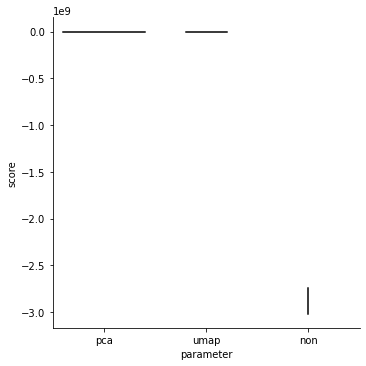

In [273]:
def test_reudction(X_train, X_test, y_train, y_test):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(X_train)
    return kde.score(X_test)
X_reduced = {'umap':X_umap, 'pca':X_umap[:,:2], 'non':X}
present_results(Analysis({reduction:[test_reudction(*train_test_split(X_reduced[reduction], y, test_size=0.25, random_state=i)) for i in range(30)] for reduction in ['pca','umap', 'non']}))

## Kernel Density Estimation

### kernel type

Mean:
gaussian      -2.874662e+09
exponential   -3.131775e+06
dtype: float64
Annova:
(103781.42837560891, 4.823662528705103e-96)
Scheffe:
                 gaussian   exponential
gaussian     1.000000e+00  4.823663e-96
exponential  4.823663e-96  1.000000e+00


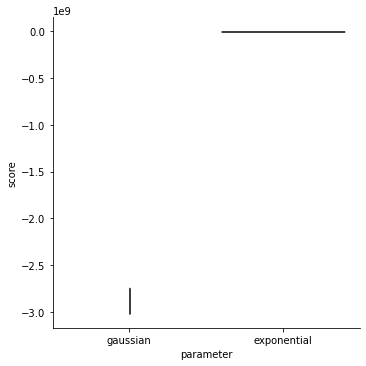

In [264]:
def test_kernel(kernel, X_train, X_test, y_train, y_test):
    kde = KernelDensity(kernel=kernel, bandwidth=0.1).fit(X_train)
    return kde.score(X_test)
present_results(Analysis({arg:[test_kernel(arg, *train_test_split(X, y, test_size=0.25, random_state=i)) for i in range(30)] for arg in ['gaussian', 'exponential']}))

### Anomly Detection

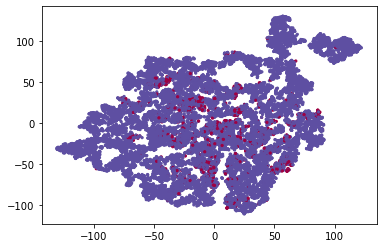

In [8]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(X_umap)
scores = kde.score_samples(X_umap)
inlires = scores > np.quantile(scores, 0.05)
#plt.scatter(X_umap_2d[:,0], X_umap_2d[:,1], c=inlires, cmap='Spectral', s=5)
plt.scatter(X_tsne_2d[:,0], X_tsne_2d[:,1], c=inlires, cmap='Spectral', s=5)

## Gaussian Mixture Model

In [213]:
from sklearn.mixture import GaussianMixture

### No of Gaussians

Mean:
2   -202.889909
3   -198.858952
4   -196.554452
5   -195.059183
6   -193.737743
dtype: float64
Annova:
(1662.8591247131674, 5.198031096176271e-120)
Scheffe:
               2             3             4              5              6
2   1.000000e+00  4.153205e-65  3.583274e-91  6.372643e-104  1.950979e-113
3   4.153205e-65  1.000000e+00  4.632451e-37   7.121415e-62   1.155213e-78
4   3.583274e-91  4.632451e-37  1.000000e+00   8.393868e-21   2.211946e-46
5  6.372643e-104  7.121415e-62  8.393868e-21   1.000000e+00   3.144200e-17
6  1.950979e-113  1.155213e-78  2.211946e-46   3.144200e-17   1.000000e+00


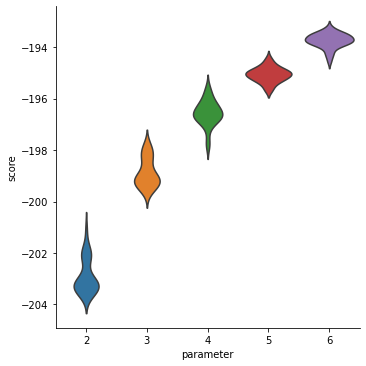

In [214]:
def test_n_gmm(n_components, X_train, X_test, y_train, y_test):
    gmm = GaussianMixture(n_components=n_components, random_state=0).fit(X_train)
    return gmm.score(X_test)
present_results(Analysis({f'{arg}':[test_n_gmm(arg, *train_test_split(X, y, test_size=0.25, random_state=i)) for i in range(30)] for arg in [2,3,4,5,6]}))

Mean:
pca     -26.122022
umap     -4.065899
non    -193.636740
dtype: float64
Annova:
(10752405.599604236, 2.5334420799992326e-235)
Scheffe:
                pca           umap            non
pca    1.000000e+00  1.151885e-150  2.900511e-227
umap  1.151885e-150   1.000000e+00  6.151556e-232
non   2.900511e-227  6.151556e-232   1.000000e+00


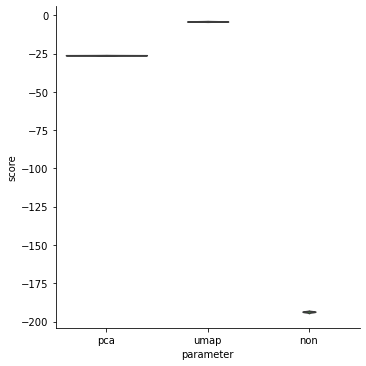

In [271]:
def test_reudction(X_train, X_test, y_train, y_test):
    gmm = GaussianMixture(n_components=6, random_state=0).fit(X_train)
    return gmm.score(X_test)
X_reduced = {'umap':X_umap, 'pca':X_pca, 'non':X}
present_results(Analysis({reduction:[test_reudction(*train_test_split(X_reduced[reduction], y, test_size=0.25, random_state=i)) for i in range(30)] for reduction in ['pca','umap', 'non']}))

Mean:
2   -203.005353
3   -198.860256
4   -196.493353
5   -194.826107
6   -193.636740
dtype: float64
Annova:
(2500.2683646080823, 1.266766609006779e-132)
Scheffe:
               2             3              4              5              6
2   1.000000e+00  1.856651e-76  3.031117e-103  3.583329e-117  1.522194e-125
3   1.856651e-76  1.000000e+00   2.403777e-46   6.699416e-75   5.359819e-90
4  3.031117e-103  2.403777e-46   1.000000e+00   9.073536e-31   6.940938e-56
5  3.583329e-117  6.699416e-75   9.073536e-31   1.000000e+00   3.915441e-19
6  1.522194e-125  5.359819e-90   6.940938e-56   3.915441e-19   1.000000e+00


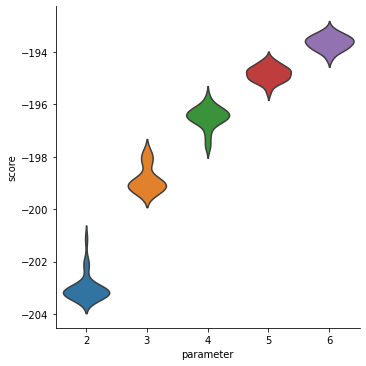

In [299]:
def test_n_gmm(n_components, X_train, X_test, y_train, y_test):
    gmm = GaussianMixture(n_components=n_components, random_state=0).fit(X_train)
    return gmm.score(X_test)
present_results(Analysis({f'{arg}':[test_n_gmm(arg, *train_test_split(X, y, test_size=0.25, random_state=i)) for i in range(30)] for arg in [2,3,4,5,6]}))

In [ ]:
gmm = GaussianMixture(n_components=6, random_state=0).fit(X_umap)
scores = gmm.score_samples(X_umap)
inlires = scores > np.quantile(scores, 0.05)
#plt.scatter(X_umap_2d[:,0], X_umap_2d[:,1], c=inlires, cmap='Spectral', s=5)
plt.scatter(X_tsne_2d[:,0], X_tsne_2d[:,1], c=inlires, cmap='Spectral', s=5)

In [217]:
from sklearn.covariance import EllipticEnvelope

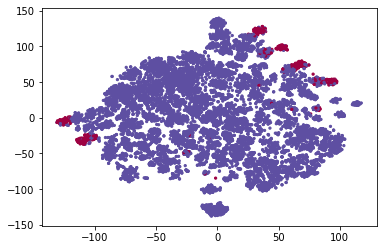

In [290]:
ee = EllipticEnvelope(random_state=0).fit(X_umap)
scores = ee.score_samples(X_umap)
inlires = scores > np.quantile(scores, 0.05)
#plt.scatter(X_umap_2d[:,0], X_umap_2d[:,1], c=inlires, cmap='Spectral', s=5)
plt.scatter(X_tsne_2d[:,0], X_tsne_2d[:,1], c=inlires, cmap='Spectral', s=5)

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
labels = LocalOutlierFactor().fit_predict(X_std)
inlires = labels != -1
plt.scatter(X_tsne_2d[:,0], X_tsne_2d[:,1], c=inlires, cmap='Spectral', s=5)

In [ ]:
from sklearn.cluster import DBSCAN
clusters = DBSCAN(eps=3, min_samples=2).fit_predict(X_std)

In [ ]:
plt.scatter(X_tsne_2d[:,0], X_tsne_2d[:,1], c=clusters == 0, cmap='Spectral', s=5)

In [9]:
from sklearn.cluster import DBSCAN
clusters = DBSCAN(eps=0.5, min_samples=5).fit_predict(X_umap)

In [11]:
from mst_clustering import MSTClustering
clusters = MSTClustering(cutoff=0.8).fit_predict(X_umap)

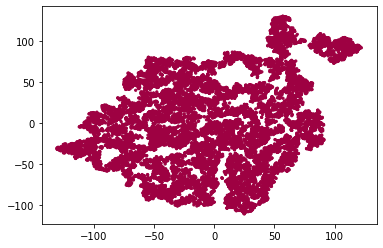

In [12]:
plt.scatter(X_tsne_2d[:,0], X_tsne_2d[:,1], c=clusters >= 0, cmap='Spectral', s=5)

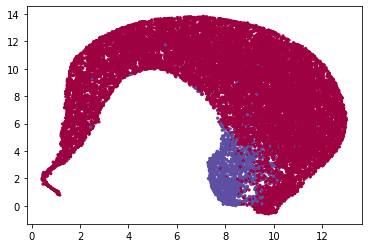

In [14]:
#real classes
plt.scatter(X_umap_2d[:,0], X_umap_2d[:,1], c=Class, cmap='Spectral', s=5)

In [ ]:
#best V score clusters 

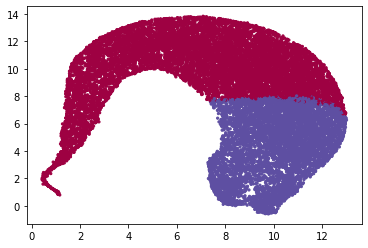

In [38]:
from sklearn.mixture import GaussianMixture
clusters = GaussianMixture(n_components=2, random_state=2, covariance_type='diag').fit_predict(X_umap)
plt.scatter(X_umap_2d[:,0], X_umap_2d[:,1], c=clusters, cmap='Spectral', s=5)